# Running Cortex Certifai Scan on Azure ML Model with authentication


## CONTENTS

1. In this tutorial we will create sklearn models to classify [german credit loan risk](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) (predict whether loan will be granted or not)

2. Register model and deploy as webservice in ACI (AZURE CONTAINER INSTANCE) with authentication

3. Test the deployed webservice

4. Run Certifai Scan on the model deployed as webservice

## Prerequisites

If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, make sure you go through the 
[configuration-notebook](https://github.com/Azure/MachineLearningNotebooks/blob/c520bd1d4130d9a01ee46e0937459e2de95d15ec/configuration.ipynb) to create an Azure workspace. Creating local and remote environments/dependencies will be covered in the notebook

**PleaseNote**: to step through this notebook, make sure you have necessary dependencies installed locally

- python>=3.6.2,<3.7
- scikit-learn=0.20.3
- numpy=1.16.2
- pandas
- azureml-sdk=1.4.0
- ipython
- matplotlib
- jupyter

You can also use [Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) to create the local environment using the `certifai_azure_model_env.yml` file provided with the notebook

Open your favorite terminal and cd into folder where this notebook is located to execute the below commands

- `conda env create -f certifai_azure_model_env.yml` : will create local conda env with the necessary python packages for working through the notebook
- `jupyter-notebook` : to launch jupyter notebook sesssion. 


**Note**: Installing `Cortex-Certifai` packages will be covered separately

### Set Cortex Certifai Toolkit path
- update the `certifai_toolkit_path` to point your downloaded toolkit
- this will be used later to install cortex certifai python packages

In [51]:
from os.path import expanduser
home = expanduser("~")
certifai_toolkit_path = f'{home}/Downloads/toolkit'
certifai_toolkit_path

'/Users/akumar/Downloads/certifai_toolkit_v1.2.13'

## Creating a [german credit](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) prediction model using sklearn

In [6]:
# required imports for model building and persistance 

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import random
from sklearn.externals import joblib

### Test to confirm correct version of scikit-learn and numpy are installed

In [44]:
import sklearn as sklearn_version_test
assert sklearn_version_test.__version__ == '0.20.3', 'scikit-learn version mismatch, `pip install scikit-learn==0.20.3` to install right sklearn version for this notebook'
assert np.__version__                   == '1.16.2', 'numpy version mismatch, `pip install numpy==1.16.2` to install right numpy version for this notebook'

In [7]:
# special import - 
# for multiprocessing to work in a Notebook,  pickled classes must be in a separate package or notebook
# hence, the model encoder class has to be somewhere other than the current notebook

import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('.')))
from scripts.cat_encoder import CatEncoder

###  load data in dataframe

In [8]:
# load the dataset into memory
df = pd.read_csv('data/german_credit_eval.csv')

### define features 

In [9]:
cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

label_column = 'outcome'

### separate features and target variable

In [10]:
y = df[label_column]
X = df.drop(label_column, axis=1)

### split dataset into the training and test set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### encode and scale features

In [12]:
encoder = CatEncoder(cat_columns, X)

### build and train model using sklearn

In [13]:
def build_model(data, name, model_family, test=None):
    if test is None:
        test = data
        
    if model_family == 'SVM':
        parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, .5, 1, 2, 4, 10], 'gamma':['auto']}
        m = svm.SVC()
    elif model_family == 'logistic':
        parameters = {'C': (0.5, 1.0, 2.0), 'solver': ['lbfgs'], 'max_iter': [1000]}
        m = LogisticRegression()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

svm_model_name      = 'german_credit_svm'
logistic_model_name = 'german_credit_logit'

svm_model = build_model((encoder(X_train.values), y_train),
                        svm_model_name,
                        'SVM',
                        test=(encoder(X_test.values), y_test))

logistic_model = build_model((encoder(X_train.values), y_train),
                        logistic_model_name,
                        'logistic',
                        test=(encoder(X_test.values), y_test))

Model 'german_credit_svm' accuracy is 0.77
Model 'german_credit_logit' accuracy is 0.76


### dump the trained models (along with corresponding encoder object) to disk 

In [14]:
# encoder object is dumped(along with trained model) to apply same transformation during prediction
def dump_model(model_name,model_obj,encoder_obj=encoder):
    model_path = f'{model_name}.pkl'
    model_obj = {
        "model":model_obj,
        "encoder":encoder_obj
    }
    joblib.dump(value=model_obj, filename=model_path)
    print(f'model saved on disk {model_obj}')
    return model_path

# persist models to disk
svm_model_disk_path      = dump_model(svm_model_name,svm_model)
logistic_model_disk_path = dump_model(logistic_model_name,logistic_model)

model saved on disk {'model': GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ('linear', 'rbf', 'poly'), 'C': [0.1, 0.5, 1, 2, 4, 10], 'gamma': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0), 'encoder': <scripts.cat_encoder.CatEncoder object at 0x1a16fd57f0>}
model saved on disk {'model': GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, ver

## In the section below we will:

1. Configure Azure workspace
2. Register models (built above) to the workspace
3. Create a prediction environment in the remote Azure workspace (created above) and
4. Deploy models (predict) as web service

### Configure and Initialize Azure workspace

- Follow the instructions listed here [creating and managing azure-ml workspace](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-manage-workspace) to create an azure-ml workspace

**Once you have the workspace created easiest way to run through remaining steps is to download the `config.json` to the current directory and replace the exisiting config.json**

### Create a [Workspace](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.workspace%28class%29?view=azure-ml-py) object from the persisted configuration.

In [16]:
from azureml.core import Workspace
ws = Workspace.from_config()

### Register models to created  workspace

Register a file or folder as a model by calling [Model.register()](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.model.model?view=azure-ml-py#register-workspace--model-path--model-name--tags-none--properties-none--description-none--datasets-none--model-framework-none--model-framework-version-none--child-paths-none-).

In addition to the content of the model file itself (model + scaler object), our registered model will also store model metadata like model description, tags, etc. -- that will be useful when managing and deploying models in our workspace.

In [17]:
from azureml.core.model import Model

logistic_model_azure = Model.register(model_path=logistic_model_disk_path,
                       model_name=logistic_model_name,
                       tags={'area': "banking credit risk", 'type': "classification"},
                       description="Logistic Classifier model to predict credit loan approval",
                       workspace=ws)

svm_model_azure = Model.register(model_path=svm_model_disk_path,
                       model_name=svm_model_name,
                       tags={'area': "banking credit risk", 'type': "classification"},
                       description="Support Vector Machine Classifier model to predict credit loan approval",
                       workspace=ws)

Registering model german_credit_logit
Registering model german_credit_svm


### Create a custom prediction environment inside azure-ml workspace

If we want control over how our model is run, if it uses another framework, or if it has special runtime requirements, we can instead specify our own environment and scoring method. Custom environments can be used for any model we want to deploy.

Specify the model's runtime environment by creating an [Environment](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.environment%28class%29?view=azure-ml-py) object and providing the [CondaDependencies](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.conda_dependencies.condadependencies?view=azure-ml-py) needed by the model

In this example we will create a conda environment for our german credit model from file **myenv.yml** and register it to our workspace


In [20]:
with open("myenv.yml", 'r') as f:
    print(f.read())

name: project_environment
dependencies:
  - python=3.6.2
  - scikit-learn==0.20.3
  - numpy==1.16.2
  - pip:
    - azureml-defaults
    - inference-schema[numpy-support]
    


In [21]:
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.environment import Environment

environment = Environment("german-credit-env")
environment.python.conda_dependencies = CondaDependencies("myenv.yml")
environment.register(workspace=ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/base:intelmpi2018.3-ubuntu16.04",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "username": null
        },
        "enabled": false,
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "german-credit-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "dependencies": [
                "python=3.6.2",
                "scikit-learn==0.20.3",
                "numpy==1.16.2",
                {
                    "pip": [
                        "azureml-defa


## Create Inference Configuration and deploy webservice

**Inference Configuration** will contain:

1. Scoring script
2. Environment (created above)

We create the scoring script, called **score.py**. The web service call uses this script to show how to use the model.

We include below two required functions in the scoring script:

1. The `init()` function, which typically loads the model into a global object. This function is run only once when the Docker container is started.

2. The `run(data)` function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization, but other formats are also supported.




Deploy the registered model in the custom environment by providing an [InferenceConfig](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.model.inferenceconfig?view=azure-ml-py) object to [Model.deploy()](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.model.model?view=azure-ml-py#deploy-workspace--name--models--inference-config--deployment-config-none--deployment-target-none-). In this case we are also using the [AciWebservice.deploy_configuration()](https://docs.microsoft.com/python/api/azureml-core/azureml.core.webservice.aci.aciwebservice#deploy-configuration-cpu-cores-none--memory-gb-none--tags-none--properties-none--description-none--location-none--auth-enabled-none--ssl-enabled-none--enable-app-insights-none--ssl-cert-pem-file-none--ssl-key-pem-file-none--ssl-cname-none--dns-name-label-none--) method to generate a custom deploy configuration
        
**Note**: This step can take several minutes.


In [26]:
with open('scripts/svm_score.py') as f:
    print(f.read())

import os
import json
import numpy as np
from sklearn.externals import joblib
import traceback


def init():
    global model
    global encoder
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'german_credit_svm.pkl')
    # deserialize the model_obj file back into a sklearn model and scaler object
    model_obj  = joblib.load(model_path)
    model      = model_obj.get('model')
    encoder    = model_obj.get('encoder')


def run(data):
    try: 
        # certifai invokes model with the json schema -> {"payload": {"instances": [ [6,107,88,0,0,36.8,0.727,31], [5,100,80,0,0,31.9,0.61,33] ]}}
        data  = json.loads(data).get('payload', {}).get('instances', [])
        data  = np.array(data, dtype=object)
        data

In [27]:
from azureml.core.model import InferenceConfig
from azureml.core import Webservice
from azureml.exceptions import WebserviceException
from azureml.core.webservice import AciWebservice

inference_config_logistic = InferenceConfig(entry_script="logistic_score.py",
                                   environment=environment,source_directory="scripts")
inference_config_svm = InferenceConfig(entry_script="svm_score.py",
                                   environment=environment,source_directory="scripts")

logistic_service_name = 'german-credit-logistic-service'
svm_service_name = 'german-credit-svm-service'

aci_deployment_config = AciWebservice.deploy_configuration(auth_enabled=True)

# Remove any existing services under the same name.
try:
    Webservice(ws, logistic_service_name).delete()
except WebserviceException:
    pass

try:
    Webservice(ws, svm_service_name).delete()
except WebserviceException:
    pass


service_logistic = Model.deploy(ws, logistic_service_name, [logistic_model_azure],inference_config=inference_config_logistic,deployment_config=aci_deployment_config)
service_svm      = Model.deploy(ws, svm_service_name,      [svm_model_azure],     inference_config=inference_config_svm,     deployment_config=aci_deployment_config)
service_logistic.wait_for_deployment(show_output=True)
service_svm.wait_for_deployment(show_output=True)

Running...................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Running.
Succeeded
ACI service creation operation finished, operation "Succeeded"


## Test the webservice

1. Get the webservice endpoint using `service.scoring_uri` :: string
2. Get the authentication headers usinh `service.get_keys()` :: tuple


In [28]:
service_logistic_uri  = service_logistic.scoring_uri
service_logistic_keys = service_logistic.get_keys()

service_svm_uri       = service_svm.scoring_uri
service_svm_keys      = service_svm.get_keys()

In [29]:
# create json test data sample(from csv)

import json
sample_input = json.dumps({
"payload": {
    "instances": [
        [
            "... < 0 DM",
            6,
            "critical account/ other credits existing (not at this bank)",
            "radio/television",
            1169,
            "unknown/ no savings account",
            ".. >= 7 years",
            4,
            "male : single",
            "others - none",
            4,
            "real estate",
            "> 25 years",
            "none",
            "own",
            2,
            "skilled employee / official",
            1,
            "phone - yes, registered under the customers name",
            "foreign - yes"
        ]
    ]
}
})
sample_input

'{"payload": {"instances": [["... < 0 DM", 6, "critical account/ other credits existing (not at this bank)", "radio/television", 1169, "unknown/ no savings account", ".. >= 7 years", 4, "male : single", "others - none", 4, "real estate", "> 25 years", "none", "own", 2, "skilled employee / official", 1, "phone - yes, registered under the customers name", "foreign - yes"]]}}'

In [30]:
import requests
import json

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {service_svm_keys[0]}'          
          }

response = requests.post(
    service_svm_uri, data=sample_input, headers=headers)
print(response.status_code)
print(response.elapsed)
print(response.json())

200
0:00:00.710408
{'payload': {'predictions': [1]}}


## Running Cortex Certifai Scan locally

1. Install the cortex certifai packages required to initiate model scan

2. Configure scan details and execute


## Installing Cortex Certifai python packages

initiating a Cortex Certifai scan requires following python packages to be installed in the current local environment

`required-packages`

- cortex-certifai-scanner
- cortex-certifai-engine
- cortex-certifai-common

`optional-packages`

- cortex-certifai-client
- cortex-certifai-console

Download [certifai toolkit](https://www.cognitivescale.com/download-certifai) and follow instructions in the `Readme.md` to install the python-packages in the current environment

### Install required certifai packages (optional packages are left for user to install)


In [84]:
!find $certifai_toolkit_path/packages/all       -type f ! -name "*console-*" ! -name "*client-*" | xargs -I % sh -c 'pip install % ' ;
!find $certifai_toolkit_path/packages/python3.6 -type f   -name "*engine-*"                      | xargs -I % sh -c 'pip install % ' ;


Processing /Users/akumar/Downloads/certifai_toolkit_v1.2.13/packages/all/cortex-certifai-common-1.2.13-102-ge0e7c71e.zip
  Created wheel for cortex-certifai-common: filename=cortex_certifai_common-1.2.13-py3-none-any.whl size=58126 sha256=341d207c0a96458f508b682af1d868f8db2862536614da765cb6fd502535d7da
  Stored in directory: /Users/akumar/Library/Caches/pip/wheels/40/8a/de/36a62fb459e5d741203bf3a1411438e9c46270a386f55a86b5
Successfully built cortex-certifai-common
  Attempting uninstall: cortex-certifai-common
    Found existing installation: cortex-certifai-common 1.2.13
    Uninstalling cortex-certifai-common-1.2.13:
      Successfully uninstalled cortex-certifai-common-1.2.13
Processing /Users/akumar/Downloads/certifai_toolkit_v1.2.13/packages/all/cortex-certifai-scanner-1.2.13-102-ge0e7c71e.zip
  Created wheel for cortex-certifai-scanner: filename=cortex_certifai_scanner-1.2.13-py3-none-any.whl size=67689 sha256=19bfff0783fc2e7b2ff9ecd65bf8e6a65d77da9325dd79caa75243da3333c25f
  Sto

  Created wheel for cortex-certifai-engine: filename=cortex_certifai_engine-1.2.13-py3-none-any.whl size=2242150 sha256=c3df76928b1ce2eaad74ca84bbe97b6d529c44a932a9e475e5d6cdcbfae45951
  Stored in directory: /Users/akumar/Library/Caches/pip/wheels/19/9c/b7/715ab8325e1bd62ee9dc6b18f441c4ca217414c1c938b5454e
Successfully built cortex-certifai-engine
  Attempting uninstall: cortex-certifai-engine
    Found existing installation: cortex-certifai-engine 1.2.13
    Uninstalling cortex-certifai-engine-1.2.13:
      Successfully uninstalled cortex-certifai-engine-1.2.13


In [86]:
# make sure certifai package was installed correctly
from certifai.scanner.version import get_version
get_version()

'1.2.13'

### Using Cortex Certifai python-package to launch a scan

In [33]:
# necessary imports for creating a scan

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe



### define cortex certifai task type

- `CertifaiTaskOutcomes` : cortex certifai supports classification as well as regression models. here we have an example of binary-classification (e.g. predict whether loan should be granted or not)
- `CertifaiOutcomeValue` : define the different outcomes possible from the model predictions. here we have a model that predicts either 1(loan granted) or 2(loan denied)

**Note**: Please refer to [Certifai Api Docs](https://cognitivescale.github.io/cortex-certifai/certifai-api-ref/certifai.scanner.builder.html) for more details

In [34]:
# Create the scan object from scratch using the ScanBuilder class with tasks and outcomes

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

#  create a certifai scan object and add the certifai task created above
scan = CertifaiScanBuilder.create('model_auth_demo',
                                  prediction_task=task)


### add logistic and svm models (created above) to scan object

In [35]:
# Create a Certifai Model Object using the web service (from earlier) by passing the deployed web service url
first_model = CertifaiModel('SVM',
                            predict_endpoint=service_svm_uri)
scan.add_model(first_model)

second_model = CertifaiModel('logistic',
                            predict_endpoint=service_logistic_uri)
scan.add_model(second_model)

# Add corresponding model headers for service authentication and content-type

# add the default headers applicable to all models
scan.add_model_header(header_name='Content-Type',header_value='application/json')

# add defined headers corresponding to auth keys for respective model services
scan.add_model_header(header_name='Authorization', header_value=f'Bearer {service_svm_keys[0]}', model_id='SVM')
scan.add_model_header(header_name='Authorization', header_value=f'Bearer {service_logistic_keys[0]}', model_id='logistic')



### add the evaluation dataset to scan object

- `evaluation dataset` dataset to be used by cortex certifai to evaluate the model against

In [36]:
# create an evaluation object and pass the evaluation dataset(csv) here 
german_credit_eval_data_file = "data/german_credit_eval.csv"
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(german_credit_eval_data_file))
scan.add_dataset(eval_dataset)

### evaluating model fairness 

- add `fairness` as evaluation type to scan object
- create an `evaluation_dataset_id` to refer to added evaluation datset

In [37]:
# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by marital status and age
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('age'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('status'))
scan.add_evaluation_type('fairness')
scan.evaluation_dataset_id = 'evaluation'

In [38]:
# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

In [39]:
# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = scan.run(write_reports=False)

2020-05-06 13:54:52,948 root   INFO     Validating license...
2020-05-06 13:54:52,950 root   INFO     License is valid - expires: n/a
2020-05-06 13:54:52,970 root   INFO     Generated unique scan id: 4d13d83bbed7
2020-05-06 13:54:52,971 root   INFO     Validating input data...
2020-05-06 13:54:52,973 root   INFO     Creating dataset with id: evaluation
2020-05-06 13:54:53,014 root   INFO     Inferring dataset features and applying user overrides
2020-05-06 13:54:53,017 root   INFO     Reading configs from: /Users/akumar/.certifai/certifai_config.ini
2020-05-06 13:54:53,019 root   INFO     Reading default config (fallback) from: /Users/akumar/miniconda/envs/certifai-azure-model-env/lib/python3.6/site-packages/certifai/common/utils/default_certifai_config.ini
2020-05-06 13:54:53,021 root   INFO     Read config marker: config['default']['marker'] = 0.1
2020-05-06 13:54:53,024 root   INFO     Integer-valued feature 'duration' inferred to be numeric (sample cardinality 33)
2020-05-06 13:54:

2020-05-06 14:46:18,046 root   INFO     Feature fairnesses are [{'feature': 'age', 'value': 61.15883350659299, 'value_confidence_95_lower': 52.73618538324422, 'value_confidence_95_upper': 70.64524765729585}, {'feature': 'status', 'value': 67.34984041646437, 'value_confidence_95_lower': 58.24331066587458, 'value_confidence_95_upper': 76.12839810454786}]
2020-05-06 14:46:18,047 root   INFO     Model used: SVM
2020-05-06 14:46:18,048 root   INFO     CERScore is 1.0615384615384615
2020-05-06 14:46:18,049 root   INFO     NCERScore is 0.07820962780049875
2020-05-06 14:46:18,049 root   INFO     Normalization constant is 13.572989558859554
2020-05-06 14:46:18,050 root   INFO     Total run time in seconds: 3070.2763526439667
2020-05-06 14:46:18,052 root   INFO     Total Samples: 1622
2020-05-06 14:46:18,053 root   INFO     Average feature reduction applied to counterfactuals: 0.0
2020-05-06 14:46:18,206 root   INFO     Completed fairness report for model SVM
2020-05-06 14:46:18,210 root   INFO 

2020-05-06 15:30:01,376 root   INFO     Model used: logistic
2020-05-06 15:30:01,377 root   INFO     CERScore is 1.0570175438596492
2020-05-06 15:30:01,378 root   INFO     NCERScore is 0.07723889367830424
2020-05-06 15:30:01,379 root   INFO     Normalization constant is 13.685042515783168
2020-05-06 15:30:01,380 root   INFO     Total run time in seconds: 2606.7361268997192
2020-05-06 15:30:01,381 root   INFO     Total Samples: 1838
2020-05-06 15:30:01,383 root   INFO     Average feature reduction applied to counterfactuals: 0.0
2020-05-06 15:30:01,513 root   INFO     Completed fairness report for model logistic
2020-05-06 15:30:01,517 root   INFO     Creating ATX report for model: logistic
2020-05-06 15:30:01,520 root   INFO     Completed all evaluations


## Analayze Fairness Results

In [87]:
# The result is a dictionary keyed on analysis, containing reports keyed on model id
# The console app is the recommended way to view these, by saving the results to file
# (see previous cell), but programmatic analysis of the result here is also possible
print(type(result['fairness']['SVM']['fairness']['secondary_scores']))
df = construct_scores_dataframe(scores('fairness', result), include_confidence=False)
display(df)

<class 'list'>


,context,type,overall fairness,Feature (age),Group details (<= 25 years),Group details (> 25 years),Feature (status),Group details (female : divorced/separated/married),Group details (male : divorced/separated),Group details (male : married/widowed),Group details (male : single)
SVM (burden),SVM,burden,60.381495,61.158834,0.094560,0.041667,67.349840,0.083887,0.069767,0.026596,0.035904
logistic (burden),logistic,burden,67.319983,74.077726,0.090659,0.053191,68.387879,0.088836,0.105000,0.035294,0.044144


##  fairness by model

,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (<= 25 years),Group details (<= 25 years) lower bound,...,Group details (female : divorced/separated/married) upper bound,Group details (male : divorced/separated),Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
SVM (burden),SVM,burden,60.381495,52.491527,68.290408,61.158834,52.736185,70.645248,0.094560,0.080000,...,0.096324,0.069767,0.042553,0.100000,0.026596,0.014535,0.040761,0.035904,0.029383,0.042495
logistic (burden),logistic,burden,67.319983,58.620645,74.782701,74.077726,64.344743,84.425494,0.090659,0.075359,...,0.100962,0.105000,0.074074,0.136792,0.035294,0.020349,0.050000,0.044144,0.037428,0.051364


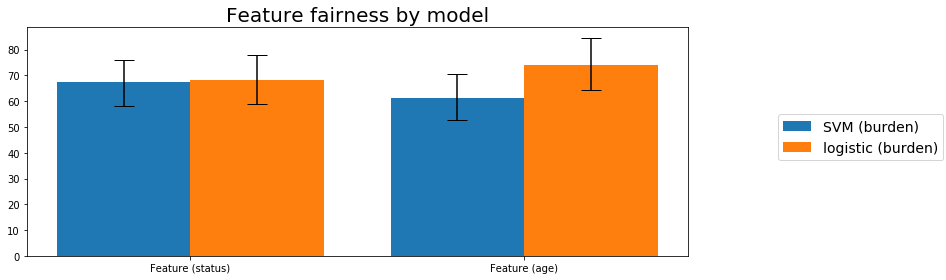

In [88]:
# Many scores also come with 95% confidence bounds, which we omitted above for the sake of brevity, but
# we can include those also.  In the example here we include the confidence bounds but only display the scores
# to a reduced level of detail to keep a smallish table for display purposes
df = construct_scores_dataframe(scores('fairness', result, max_depth=1))
display(df)

print("\n")

# Let's chart the fairness measure by feature for each model together with its confidence bounds for
# easier visual comparison:
%matplotlib inline
import matplotlib.pyplot as plt

features = ['Feature (status)', 'Feature (age)']
feature_scores = df[features]
feature_lower_bounds = df[[f + ' lower bound' for f in features]]
feature_upper_bounds = df[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Feature fairness by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()


## Resource Cleanup


- In this tutorial we
 - created and registered `logistic_model_azure` and `svm_model_azure` models to our Azure workspace
 - created `german-credit-logistic-service` and `german-credit-svm-service` ACI (Azure Container Instance) webservices 

- Once Cortex Certifai evaluation is complete, make sure to clear all azure resources in order to avoid cost
- Follow the [Azure Ml resource cleanup docs][1] to remove all resources created above

[1]:https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-1st-experiment-sdk-train#clean-up-resources